### 2(4) Geometry
패키지 설치 오류를 방지하기 위해 Google Colab을 사용하였다.<br>
[참고] https://thlee33.medium.com/osmnx%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EB%8F%84%EB%A1%9C-%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC-%EB%B6%84%EC%84%9D-59b543eb7836<br>
[참고] https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb

### Install

In [ ]:
# https://joshkobeng.medium.com/installing-osmnx-on-windows-cc96a3b432ea

In [ ]:
pip install osmnx
pip install haversine

### Import
import 전 런타임을 재시작해야 한다.

In [2]:
import numpy as np
import pandas as pd
# import osmnx as ox
# import networkx as nx
from haversine import haversine 
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [3]:
train = pd.read_csv('../data/raw/train.csv', usecols=['id','start_latitude','start_longitude','end_latitude','end_longitude'])
test = pd.read_csv('../data/raw/test.csv', usecols=['id','start_latitude','start_longitude','end_latitude','end_longitude'])

In [4]:
train.iloc[0]

id                 TRAIN_0000000
start_latitude         33.427747
start_longitude       126.662612
end_latitude           33.427749
end_longitude         126.662335
Name: 0, dtype: object

### `osmnx`

In [2]:
north = 33 + (33/60) + (50/3600)
south = 33 + (11/60) + (27/3600)
east = 126 + (58/60) + (20/3600)
west = 126 + (8/60) + (43/3600)

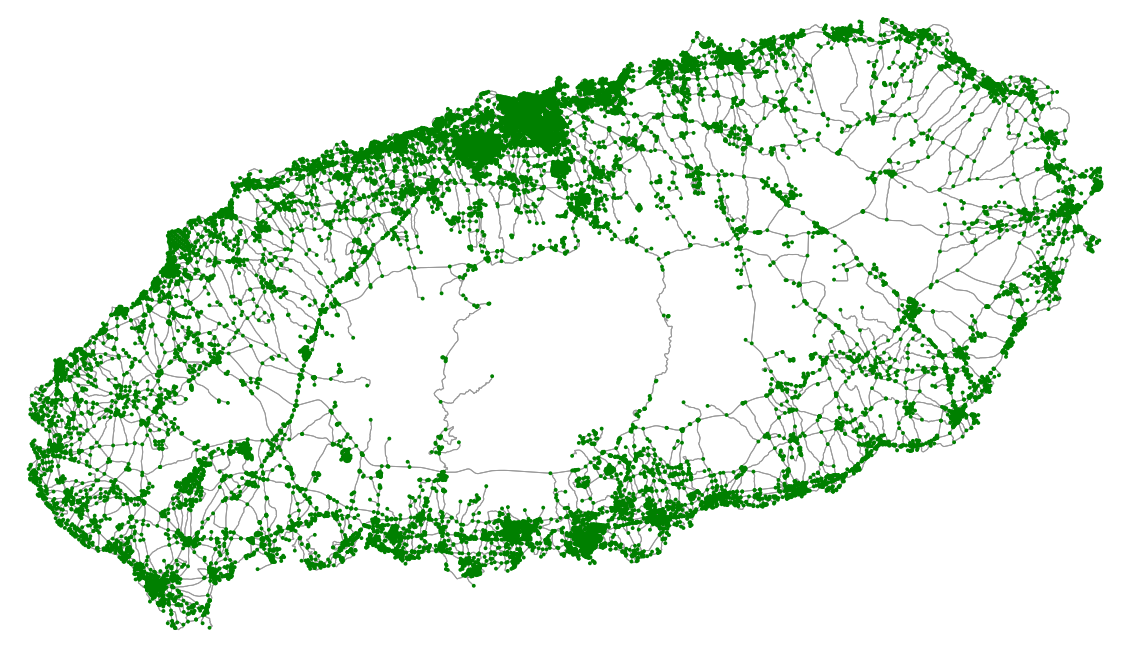

In [3]:
G = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
fig, ax = ox.plot_graph(G, figsize=(20,20), bgcolor = 'white', node_color='g', save=True, filepath="osmnx_jeju_graph.png")

In [25]:
def between_twopoint(DATA):
    EASE = DATA.drop_duplicates(['start_latitude','start_longitude','end_latitude','end_longitude'])\
           [['start_latitude','start_longitude','end_latitude','end_longitude']]
    UNIQUE = []
    for _, SLAT, SLON, ELAT, ELON in EASE.itertuples():
        orig_node, dest_node = ox.get_nearest_node(G, (SLAT, SLON)), ox.get_nearest_node(G, (ELAT, ELON)) 
        if orig_node != dest_node:
            # 최단거리(meter)
            route = ox.shortest_path(G, orig_node, dest_node, weight='length')
            length = sum(ox.utils_graph.get_route_edge_attributes(G, route, "length"))
            # 평균속도
            route = ox.shortest_path(G, orig_node, dest_node, weight='speed_kph')
            speed = np.mean(ox.utils_graph.get_route_edge_attributes(G, route, "speed_kph"))
            # 소요시간
            route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
            time = sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time"))
        else:
            # 좌표가 근접하여 같은 노드로 인식될 경우 하버사인 거리로 length를 채우고 
            # 속도, 시간은 같은 length를 갖는 값들의 평균으로 구한다.
            length, speed, time = haversine((SLAT,SLON),(ELAT,ELON), unit='m') , 0, 0
        UNIQUE.append([SLAT, SLON, ELAT, ELON, length, speed, time])
    RETURN = pd.DataFrame(UNIQUE, columns=['start_latitude','start_longitude','end_latitude','end_longitude','length','speed','time'])
    return RETURN

In [14]:
# 추출정보로 속도, 시간을 추가한다.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [26]:
unique_train = between_twopoint(train)
unique_test = between_twopoint(test)

In [ ]:
# train speed, time 결측치 처리
ease = pd.merge(unique_train, train, on=['start_latitude','start_longitude','end_latitude','end_longitude'])
length_error = ease.query('speed!=0').groupby('speed')['length'].std().mean()
unique_train['speed'] = unique_train[['length','speed']]\
                       .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['speed'].mean() if x[1]==0 else x[1], axis=1)

length_error = ease.query('time!=0').groupby('time')['length'].std().mean()
unique_train['time'] = unique_train[['length','time']]\
                      .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['time'].mean() if x[1]==0 else x[1], axis=1)    

In [ ]:
# test speed, time 결측치 처리
ease = pd.merge(unique_test, test, on=['start_latitude','start_longitude','end_latitude','end_longitude'])
length_error = ease.query('speed!=0').groupby('speed')['length'].std().mean()
unique_test['speed'] = unique_test[['length','speed']]\
                       .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['speed'].mean() if x[1]==0 else x[1], axis=1)

length_error = ease.query('time!=0').groupby('time')['length'].std().mean()
unique_test['time'] = unique_test[['length','time']]\
                      .apply(lambda x: ease.query('@x[0]-@length_error <= length <= @x[0]+@length_error')['time'].mean() if x[1]==0 else x[1], axis=1)        

In [28]:
geometry_train = pd.merge(train, unique_train, on=['start_latitude','start_longitude','end_latitude','end_longitude']).sort_values('id').reset_index(drop=True)
geometry_test = pd.merge(test, unique_test, on=['start_latitude','start_longitude','end_latitude','end_longitude']).sort_values('id').reset_index(drop=True)
print('geometry_train.shape:', geometry_train.shape)
print('geometry_test.shape:', geometry_test.shape)

geometry_train.shape: (4701217, 8)
geometry_test.shape: (291241, 8)


In [30]:
geometry_train.to_csv('geometry_train.csv', index=False)
geometry_test.to_csv('geometry_test.csv', index=False)

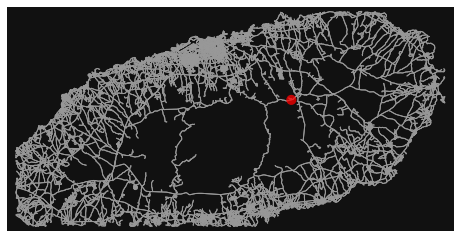

In [ ]:
# route = nx.shortest_path(G, orig_node, dest_node, weight='length')
# fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# edges = ox.graph_to_gdfs(G, nodes=False)
# edges